In [7]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import pandas as pd
import numpy as np

import CarImageClass

device = "cuda" if torch.cuda.is_available() else "cpu"

# desktop or laptop
machine = 'laptop'

# Setup path to data folder
if machine == 'laptop':
    folder_path = Path(r"C:\self-driving-car\data")
else:
    folder_path = Path(r"C:\Udacity_car_data\data")

train_path = folder_path / "train"
test_path = folder_path / "test"

In [8]:
# load training data
train_data = CarImageClass.ImageClass(targ_dir=train_path, file_list=None, transform=None, file_pct=1, rand_seed=724, include_area=True, device='cpu')

Look at some images!

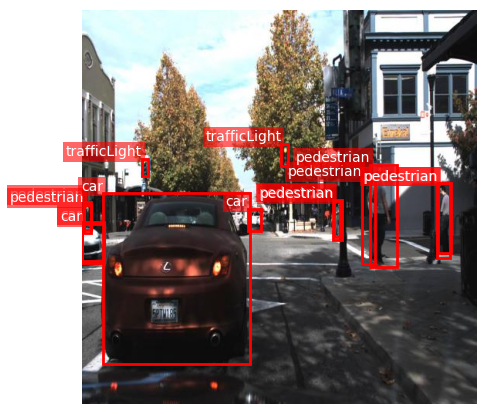

In [16]:
rand_idx = np.random.randint(0, len(train_data))

# set label=False to turn of labels
# set lw=0 to turn off bounding boxes
train_data.show_with_box(index=rand_idx, color='r', lw=2, label=True);

What is the class distribution?

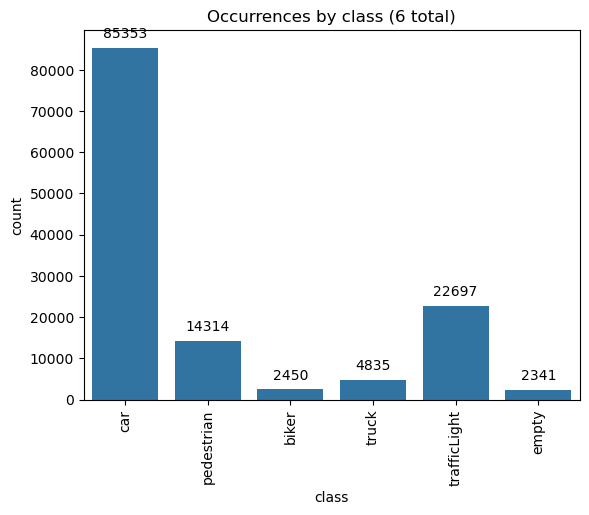

In [10]:
df = train_data.annotate_df

ax = sns.countplot(x=df['class'])

# Annotate counts above each bar
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(
        str(count), 
        (p.get_x() + p.get_width() / 2., p.get_height()),  # position
        ha='center', va='bottom',                         # alignment
        xytext=(0, 5), textcoords='offset points'         # offset above bar
    )

plt.xticks(rotation=90)
plt.title(f"Occurrences by class ({len(df['class'].unique())} total)")
plt.show()

Class distribution is unbalanced!

In [11]:
overall_total = len(df)
for class_name in df['class'].unique().tolist():
    class_total = len(df[df['class'] == class_name])
    print(f"The {class_name} class is {(class_total / overall_total) * 100:.2f} percent of all classes present.")
    print()

The car class is 64.67 percent of all classes present.

The pedestrian class is 10.84 percent of all classes present.

The biker class is 1.86 percent of all classes present.

The truck class is 3.66 percent of all classes present.

The trafficLight class is 17.20 percent of all classes present.

The empty class is 1.77 percent of all classes present.



What are the sizes of typical bounding boxes in this dataset?

In [41]:
# Get areas and area percentage of each bounding box
df = train_data.annotate_df
df['area'] = (df['xmax'] - df['xmin']) * (df['ymax'] - df['ymin'])
df['area_pct'] = df['area'] / (512 * 512)

df['area_pct'].describe()

count    129649.000000
mean          0.012420
std           0.031677
min           0.000015
25%           0.001419
50%           0.003090
75%           0.008694
max           0.514893
Name: area_pct, dtype: float64

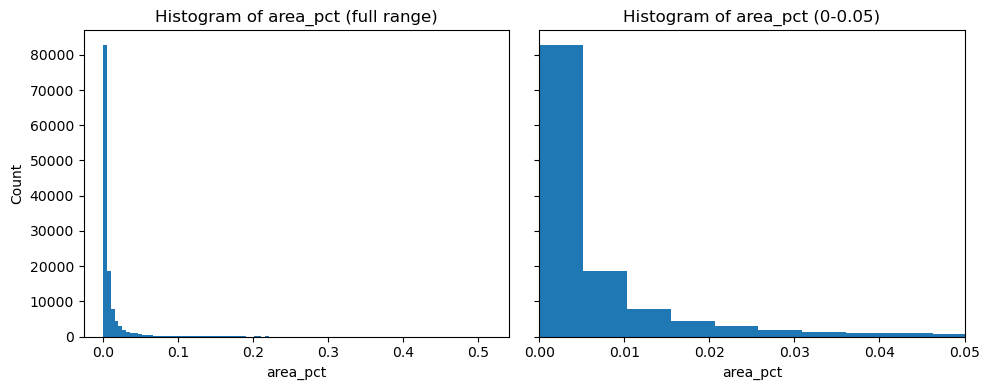

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# Left: full range
axes[0].hist(df["area_pct"], bins=100)
axes[0].set_xlabel("area_pct")
axes[0].set_ylabel("Count")
axes[0].set_title("Histogram of area_pct (full range)")

# Right: zoomed in
axes[1].hist(df["area_pct"], bins=100)
axes[1].set_xlim(0, 0.05)  # zoom on main mass
axes[1].set_xlabel("area_pct")
axes[1].set_title("Histogram of area_pct (0-0.05)")

plt.tight_layout()
plt.show()

We can see that the vast majority of bounding boxes are small.